This notebook explores methods for calculating MLD globally on llc4320 data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import numpy as np
import dask
import dask.array as da
import numcodecs

from fastjmd95 import jmd95numba 

import cmocean

open LLC4320, make a skeleton zarr file for future MLD writing

In [2]:
t_0 = 432
t_iter = (365 * 24)
t_1 = t_0 + t_iter 

# face
#face = [7,10]

# FOR TESTING: horizontal slices:
h_0, h_1  = 0,4320#2000, 2540
LLC = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)[['Theta', 'Salt', 'Z','XC','YC']].isel(time=slice(t_0,t_1), i = slice(h_0, h_1),j=slice(h_0,h_1),drop=False)

In [9]:
# native horizontal sizes
nt = LLC.dims["time"]
nf = LLC.dims["face"]
nj = LLC.dims["j"]
ni = LLC.dims["i"]

# lazy array
MLD_lazy = da.empty(
    shape=(nt, nf, nj, ni),
    chunks=(730, 1, 720, 720), #24, 540
    dtype=np.float32,
)

MLD_ds = xr.Dataset(
    {
        "MLD": (("time", "face", "j", "i"), MLD_lazy)
    },
    coords={
        "time": LLC.time,
        "face": LLC.face,
        "j": LLC.j,
        "i": LLC.i,
    },
)

compressor = numcodecs.Blosc(cname='zstd', clevel=3, shuffle=numcodecs.Blosc.BITSHUFFLE)

encoding = {
    "MLD": {
        "chunks": (730, 1, 720, 720), #24, 540
        "compressor": compressor,
        "dtype": "float32",
        "_FillValue": np.nan,
    },
    "time": {"chunks": (nt,), "dtype": "int64"},
    "face": {"chunks": (nf,), "dtype": "int32"},
    "j": {"chunks": (nj,), "dtype": "int32"},
    "i": {"chunks": (ni,), "dtype": "int32"},
}


MLD_ds.to_zarr(
    "/orcd/data/abodner/002/cody/MLD_llc4320/MLD_ds.zarr",
    mode="w",
    encoding=encoding,
    consolidated=True,
    zarr_format=2,
    compute=False
)

/tmp/ipykernel_3478594/1712153067.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nt = LLC.dims["time"]
/tmp/ipykernel_3478594/1712153067.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nf = LLC.dims["face"]
/tmp/ipykernel_3478594/1712153067.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nj = LLC.dims["j"]
/tmp/ipykernel_3478594/1712153067.py:5: FutureWarning: The return type of

Delayed('_finalize_store-55f116b0-d392-4eac-b5f6-886ec620a033')

In [3]:
MLD = xr.open_zarr('/orcd/data/abodner/002/cody/MLD_llc4320/MLD_ds.zarr',consolidated=True)

In [4]:
data1 = '/orcd/data/abodner/002/cody/MLD_per_pixel/MLD_test_face7_(432,9192)_((2000, 2540))'
MLD_1 = xr.open_zarr(f'{data1}.zarr',consolidated=False)
# take temporal average of MLD1, grab oct
MLD_nov_1 = MLD_1.resample(time="MS").mean().isel(time=1).compute()

In [5]:
# grab 2000:2540 temporal average of output to test, grab nov
MLD_comparison_test = MLD.isel(face=7,i=slice(2000,2540),j=slice(2000,2540))
MLD_nov_final = MLD_comparison_test.resample(time="MS").mean().isel(time=1).compute()

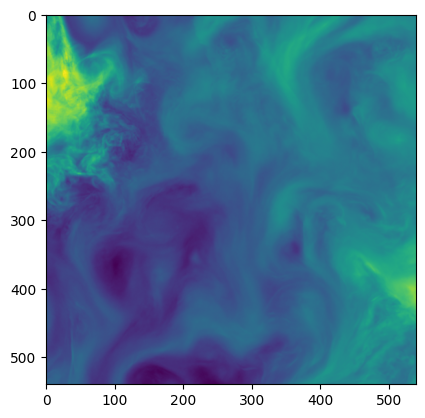

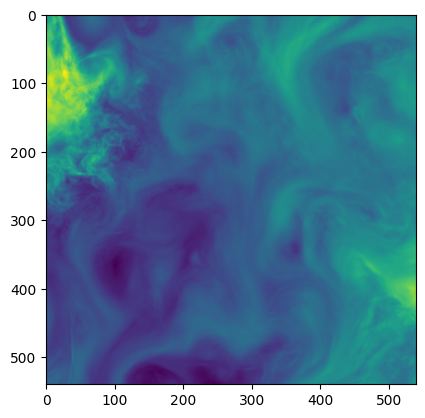

In [6]:
plt.imshow(MLD_nov_1['MLD_pixels'])
plt.show()
plt.imshow(MLD_nov_final['MLD'])

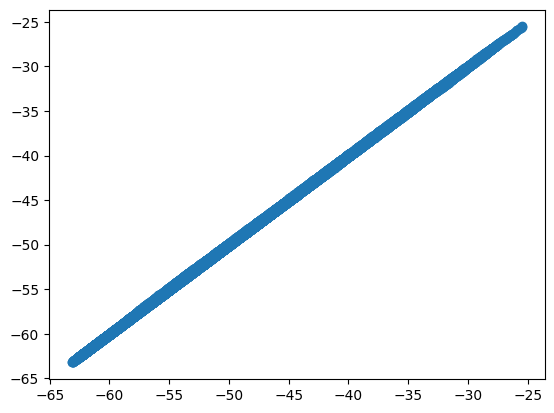

In [7]:
plt.scatter(MLD_nov_final['MLD'].values.flatten(), MLD_nov_1['MLD_pixels'].values.flatten())

In [35]:
sub = MLD.MLD.isel(time=730,face=7)

In [44]:
MLD.isel(time=slice(730,1459,)).time

<xarray.DataArray 'time' (time: 729)> Size: 6kB
array(['2011-10-31T10:00:00.000000000', '2011-10-31T11:00:00.000000000',
       '2011-10-31T12:00:00.000000000', ..., '2011-11-30T16:00:00.000000000',
       '2011-11-30T17:00:00.000000000', '2011-11-30T18:00:00.000000000'],
      shape=(729,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 6kB 2011-10-31T10:00:00 ... 2011-11-30T18:...

In [2]:
MLD_comparison_test = xr.open_zarr('/orcd/data/abodner/002/cody/MLD_llc4320/MLD_ds_large_spatial_test.zarr',consolidated=True)

In [5]:
mld_t0 = MLD_comparison_test.isel(time=0)

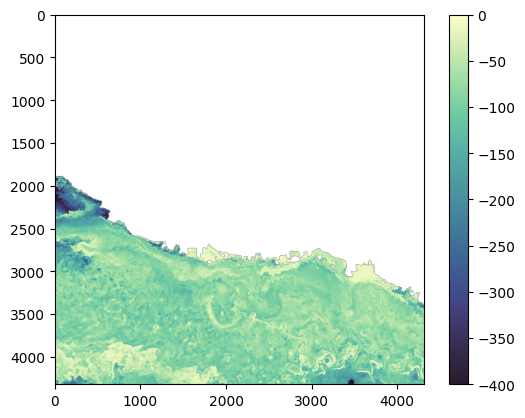

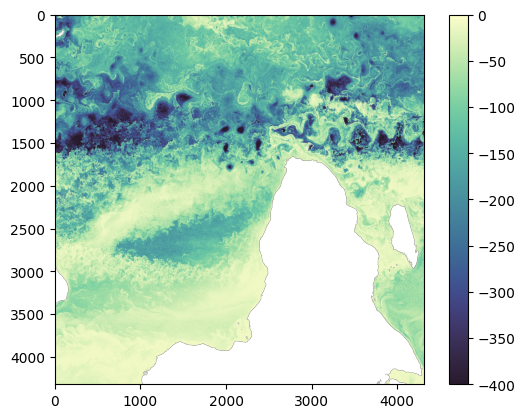

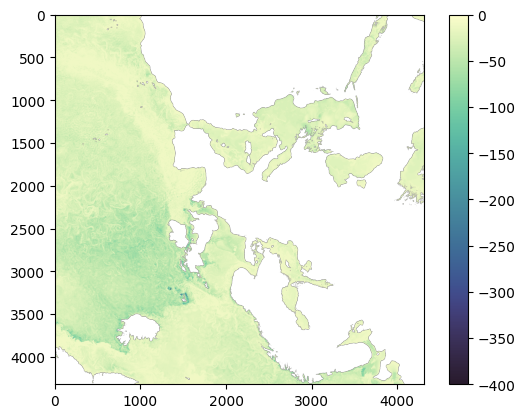

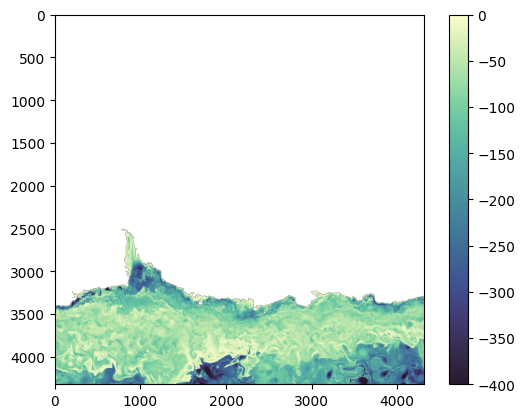

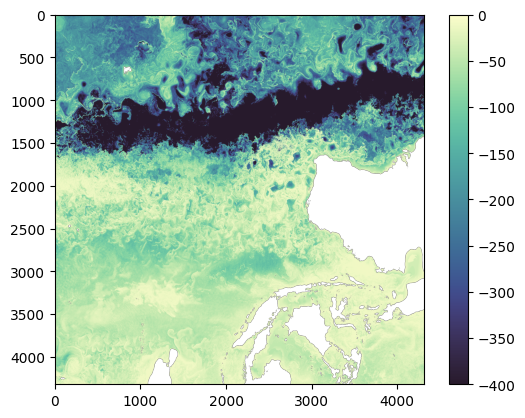

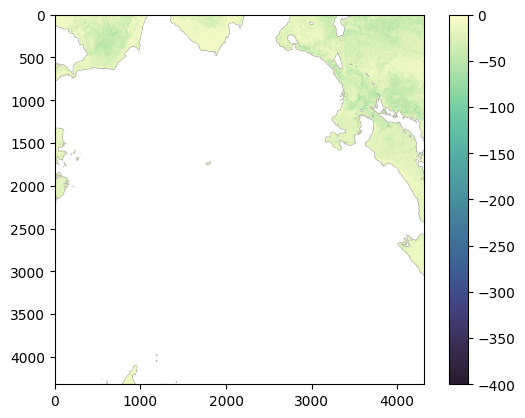

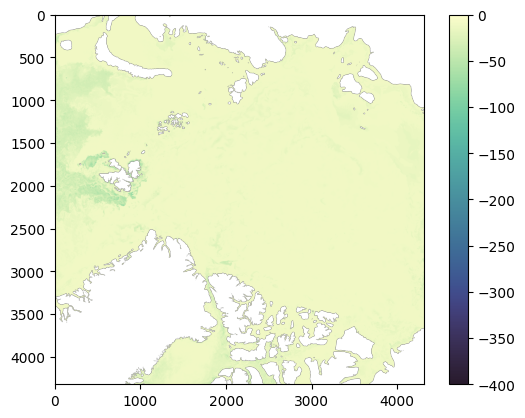

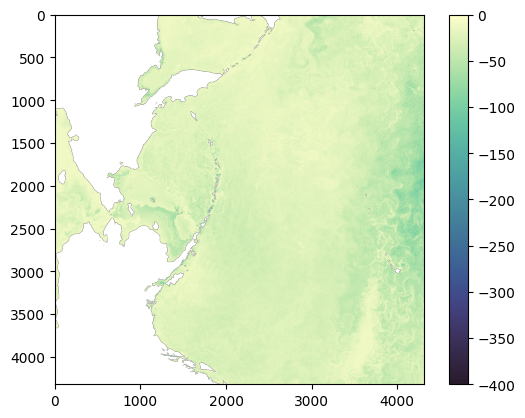

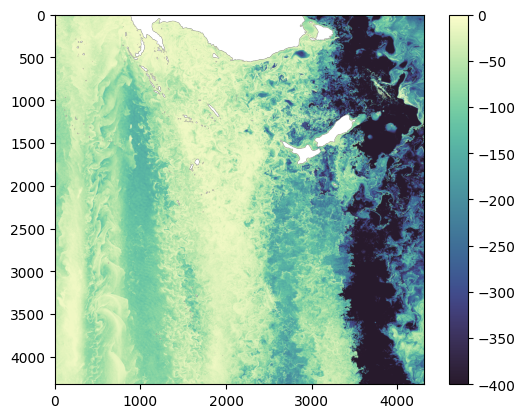

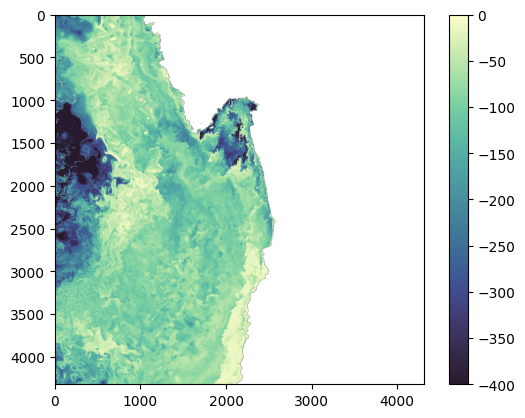

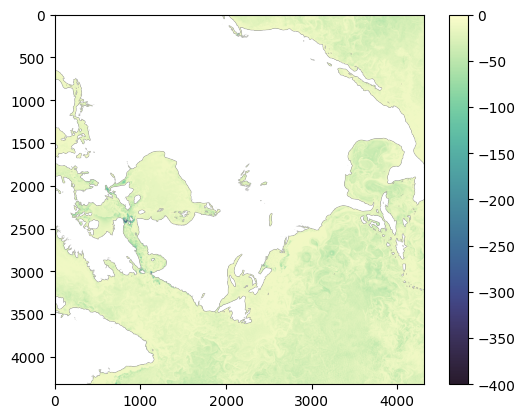

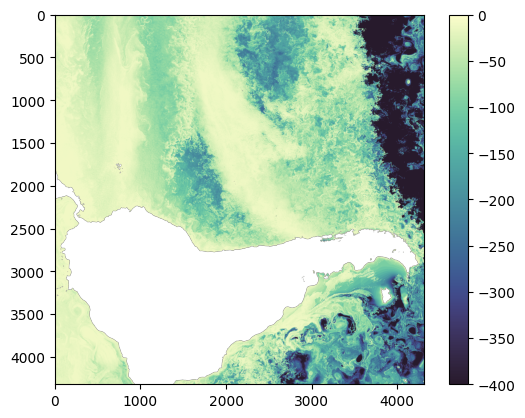

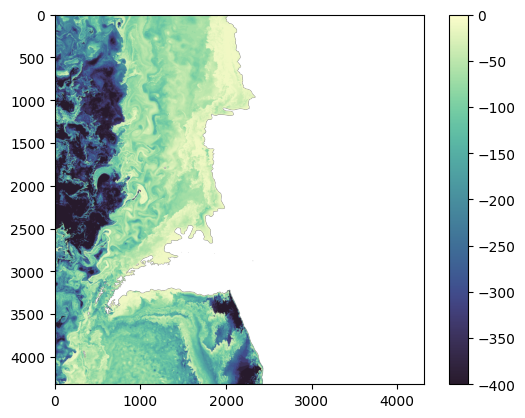

In [21]:
for n, face in enumerate(mld_t0.face):
    plt.imshow(mld_t0.MLD.isel(face=n), vmin=-400,vmax=0,cmap = cmocean.cm.deep_r)
    plt.colorbar()
    plt.show()

In [5]:
MLD_comparison_test.time

<xarray.DataArray 'time' (time: 1460)> Size: 12kB
array(['2011-10-01T00:00:00.000000000', '2011-10-01T01:00:00.000000000',
       '2011-10-01T02:00:00.000000000', ..., '2011-11-30T17:00:00.000000000',
       '2011-11-30T18:00:00.000000000', '2011-11-30T19:00:00.000000000'],
      shape=(1460,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 12kB 2011-10-01 ... 2011-11-30T19:00:00

In [6]:
# take temporal average of comparison test, grab oct
MLD_comparison_test = MLD_comparison_test.isel(face=0)
MLD_oct_4 = MLD_comparison_test.resample(time="MS").mean().isel(time=0).compute()

In [7]:
MLD_oct_4

<xarray.Dataset> Size: 1MB
Dimensions:  (j: 540, i: 540)
Coordinates:
    face     int32 4B 7
  * i        (i) int32 2kB 2000 2001 2002 2003 2004 ... 2535 2536 2537 2538 2539
  * j        (j) int32 2kB 2000 2001 2002 2003 2004 ... 2535 2536 2537 2538 2539
    time     datetime64[ns] 8B 2011-10-01
Data variables:
    MLD      (j, i) float32 1MB -39.07 -38.72 -38.52 ... -36.97 -36.97 -36.88

In [ ]:
data1 = '/orcd/data/abodner/002/cody/MLD_per_pixel/MLD_test_face7_(432,9192)_((2000, 2540))'
MLD_1 = xr.open_zarr(f'{data1}.zarr',consolidated=False)
# take temporal average of MLD1, grab oct
MLD_oct_1 = MLD_1.resample(time="MS").mean().isel(time=0).compute()


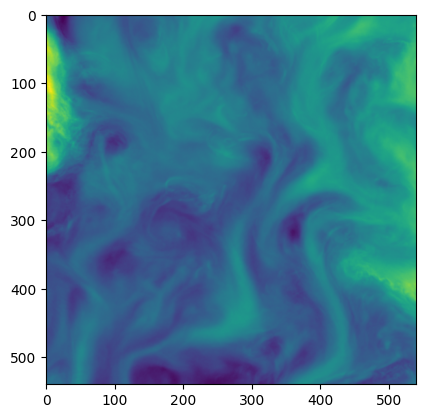

In [10]:
plt.imshow(MLD_oct_4['MLD'])

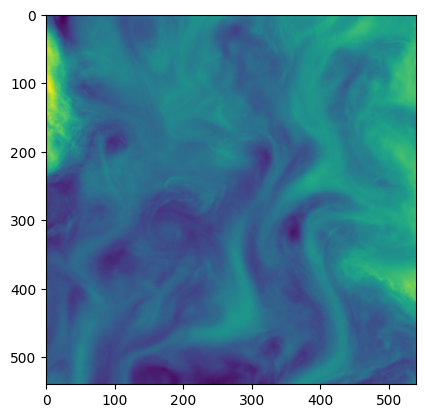

In [12]:
plt.imshow(MLD_oct_1['MLD_pixels'])

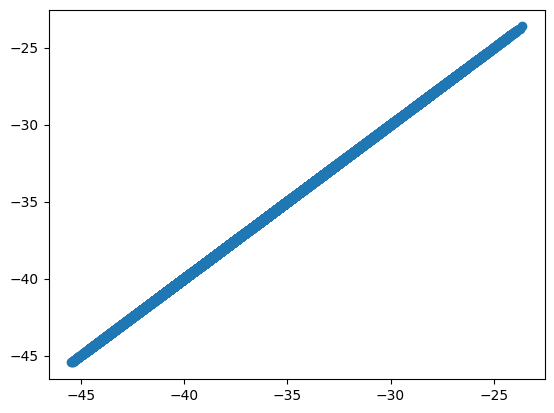

In [ ]:
plt.scatter(MLD_oct_4['MLD'].values.flatten(), MLD_oct_1['MLD_pixels'].values.flatten())

In [9]:
print(LLC.isel(face=0,i=0,j=0).XC.values, LLC.isel(face=0,i=0,j=4319).XC.values, LLC.isel(face=0,i=0,j=0).YC.values,LLC.isel(face=0,i=4319,j=0).YC.values)

142.00089 -128.00089 67.49985 13.746807


In [ ]:
MLD_test = xr.open_zarr('/orcd/data/abodner/002/cody/MLD_llc4320/MLD_ds_test.zarr',consolidated=True)
MLD_test.time

In [10]:
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

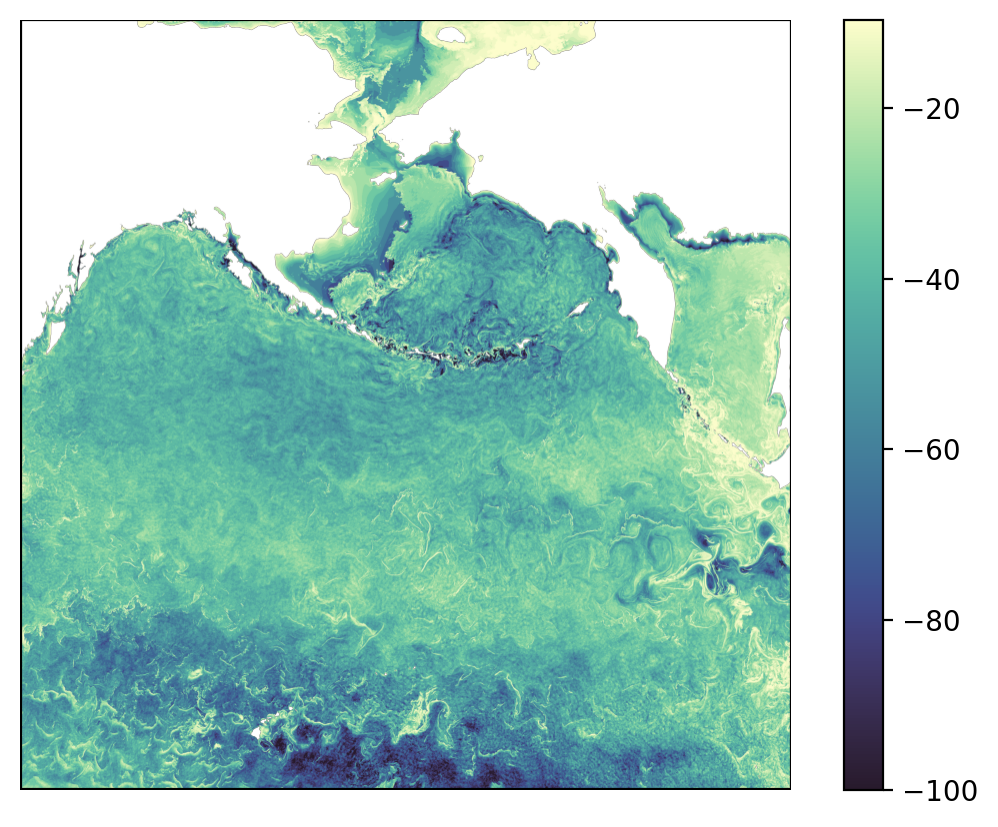

In [16]:
fig, ax = plt.subplots(figsize=(7,5),dpi=200)
plot = ax.imshow(MLD_test.MLD.isel(time=719,face=0),vmin=-100,cmap = cmocean.cm.deep_r,)
plt.colorbar(plot, ax = ax)
rotate_axes_90_clockwise(ax)
ax.set_xlim(0,4320)
plt.show()